In [86]:
# Étape 1 : Imports
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Étape 2 : Chargement des données

# Charger ton fichier de features
df = pd.read_csv("../features/features_transactions.csv") 
print("features charge")

features charge


In [87]:
#-------------------- algorithme Isolation Forest---------

# Etape 3 : pretraitement des donnees 

#selection des colonnes numeriques
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns 

# Remplacement des valeurs manquantes par 0
df[numeric_cols] = df[numeric_cols].fillna(0) 

X_scaled = df[numeric_cols]

print("normalisation reussi")

normalisation reussi


In [88]:
# Construction du pipeline avec StandardScaler + PCA + IsolationForest
pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Normalisation des données
    ('pca', PCA(n_components=2)),         # Réduction de dimension
    ('model', IsolationForest(
        contamination=0.1,
        n_estimators=50,
        random_state=42
    ))
])

# Entraînement du pipeline
pipeline.fit(X_scaled)

# Sauvegarde du pipeline complet
with open("../models/isolation_transaction.pkl", "wb") as fichier:
    pickle.dump(pipeline, fichier)

print("Pipeline Isolation Forest Transaction + PCA + Scaler sauvegardé avec succès.")

Pipeline Isolation Forest Transaction + PCA + Scaler sauvegardé avec succès.


Pipeline chargé avec succès.
Nouvelles données chargées et préparées.
Prédiction terminée.


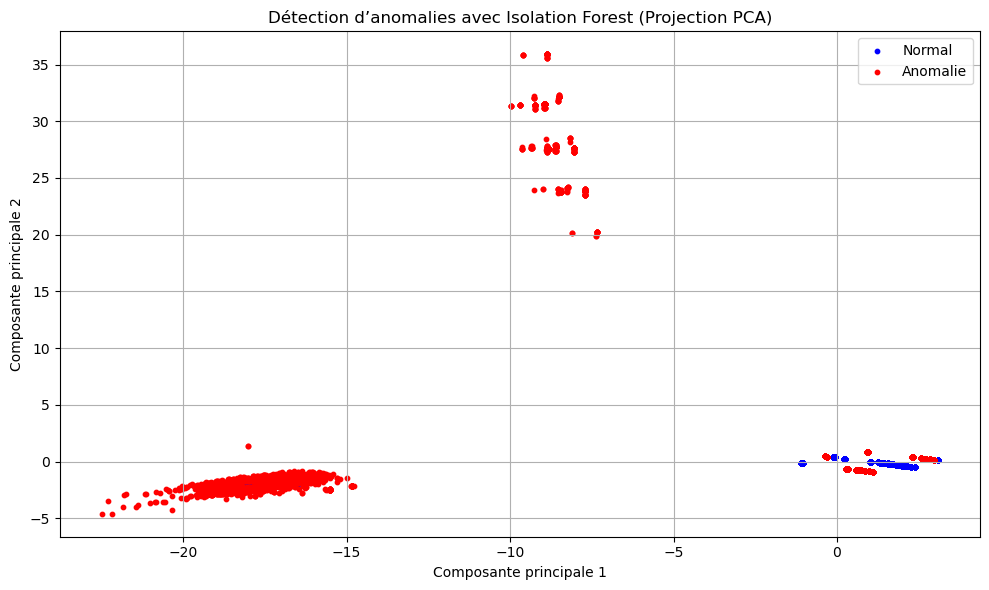

In [89]:
# Chargement du pipeline sauvegardé
with open("../models/isolation_transaction.pkl", "rb") as fichier:
    pipeline = pickle.load(fichier)

print("Pipeline chargé avec succès.")

# --------------------- Chargement de nouvelles données ----------------------

# On reprend les mêmes données pour simuler une prédiction 
features_df = pd.read_csv("../features/features_transactions.csv") 
numeric_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
X_new = features_df[numeric_cols].fillna(0)

print("Nouvelles données chargées et préparées.")

# --------------------- Prédiction ----------------------

# Prédiction des anomalies (Isolation Forest renvoie -1 pour anomalie et 1 pour normal)
y_pred = pipeline.predict(X_new)

print("Prédiction terminée.")

# --------------------- Visualisation des résultats ----------------------

# Transformation des données pour affichage (PCA réduit à 2 dimensions)
X_transformed = pipeline.named_steps['pca'].transform(pipeline.named_steps['scaler'].transform(X_new))

# Création du graphe
plt.figure(figsize=(10, 6))

# Points normaux
plt.scatter(
    X_transformed[y_pred == 1, 0], 
    X_transformed[y_pred == 1, 1], 
    c='blue', label='Normal', s=10
)

# Points anormaux
plt.scatter(
    X_transformed[y_pred == -1, 0], 
    X_transformed[y_pred == -1, 1], 
    c='red', label='Anomalie', s=10
)

# Habillage du graphe
plt.title("Détection d’anomalies avec Isolation Forest (Projection PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Affichage du graphe
plt.show()

In [90]:
# Etape 7 : Ajouter les prédictions au DataFrame original

# Ajout d'une colonne is_fraud : 1 pour fraude, 0 pour normal
features_df['is_fraud'] = [1 if x == -1 else 0 for x in y_pred]

#. Afficher le nombre total de fraudes détectées
nombre_fraudes = features_df['is_fraud'].sum()
print(f"Nombre de fraudes détectées : {nombre_fraudes}")

# 3. Extraire les transactions suspectes
features_df_fraudes = features_df[features_df['is_fraud'] == 1]

# Sauvegarde (ajout de is_fraud au dataset)
features_df.to_csv("../features/features_transactions_isolation_forest_pipeline_avec_fraude.csv", index=False)
print("Fichier enrichi avec is_fraud exporté.")

Nombre de fraudes détectées : 3799
Fichier enrichi avec is_fraud exporté.


In [91]:
# Rapport de fraude

# Charger les utilisateurs avec les noms
features_df = pd.read_csv("../features/features_transactions.csv")
user_df = pd.read_csv("../datasets/user.csv")`
user_df = user_df[['id', 'username', 'matricule']]
user_df.rename(columns={'id': 'user_id'}, inplace=True)  # Pour éviter conflit avec id dans df_fraude

# Charger le fichier des fraudes détectées (contenant la colonne is_fraud)
df_fraude = pd.read_csv('../features/features_transactions_isolation_forest_pipeline_avec_fraude.csv')

# S’assurer que les deux colonnes user_id sont de même type
df_fraude['user_id'] = df_fraude['user_id'].astype(int)
user_df['user_id'] = user_df['user_id'].astype(int)
df_fraude['user_id'] = range(1, len(df_fraude) + 1)

# Fusionner pour ajouter le nom d’utilisateur
df_rapport = pd.merge(df_fraude, user_df[['user_id', 'username', 'matricule']], on='user_id', how='left')

# Regles:

# Règle B1 : montant par jour > 1.000.000 pour un compte personnel
features_df['b1_montant_suspect'] = features_df.apply(
    lambda row: 1 if row.get('signup_mode_PERSONNAL') == 1 and row.get('montant_par_jour', 0) > 1_000_000 else 0,
    axis=1
)

# Règle B2 : KYC absent
features_df['b2_kyc_absent'] = features_df.get('kyc_status_NOT_INITIATED', 0).fillna(0).astype(bool).astype(int)

# Règle B3 : montant > solde
features_df['b3_montant_trade_exces'] = features_df.apply(lambda row: 1 if row['amount'] > row.get('trade_balance', 0) else 0, axis=1)

#
colonnes_regles = ['b1_montant_suspect', 'b2_kyc_absent', 'b3_montant_trade_exces']
for col in colonnes_regles:
    if col in features_df.columns:
        df_rapport[col] = features_df[col]

# Description
def generer_description(row):
    raisons = []
    if row.get('b1_montant_suspect', False):
        raisons.append("Montant élevé détecté sur une journée")
    if row.get('b2_kyc_absent', False):
        raisons.append("KYC non validé")
    if row.get('b3_montant_trade_exces', False):
        raisons.append("Montant superieur au solde")
    return "/ ".join(raisons) if raisons else "comportement suspect détecté par le modèle"
    
# Application
df_rapport['description'] = df_rapport.apply(
    lambda row: generer_description(row) if row['is_fraud'] == 1 else "",
    axis=1
)

# . Sélection des colonnes intéressantes pour le rapport
colonnes_affichage = ['user_id', 'username_y', 'matricule_y', 'is_fraud', 'description']
rapport_final = df_rapport[df_rapport['is_fraud'] == 1][colonnes_affichage]

# .suppression des lignes avec des valeurs manquantes (NaN)
rapport_final = rapport_final.dropna(subset=['matricule_y', 'username_y', 'user_id'])

#9. Convertir la colonne 'id' en int
rapport_final['user_id'] = rapport_final['user_id'].astype(int)

# Exporter vers CSV
rapport_final.to_csv("../features/rapport_fraude_transactions_isoforest_pipeline.csv", index=False)

# Affichage d’un aperçu
print("Utilisateurs détectés comme fraudeurs :")
display(rapport_final.head())

Utilisateurs détectés comme fraudeurs :


,user_id,username_y,matricule_y,is_fraud,description
0,1,bruyan,SP20201A,1,KYC non validé
5,6,xpimentOld,SP20202A,1,KYC non validé
7,8,sopay,SP20208U,1,KYC non validé
15,16,MYSOLEAS,SP202116A,1,KYC non validé
16,17,perlita,SP202117U,1,KYC non validé


In [94]:
#---------------------- algorithme SVM ---------

from sklearn.svm import OneClassSVM #import de bibliotheque OneClasssSvm

# Etape 1 : pretraitement des donnees 

#selection des colonnes numeriques
df = pd.read_csv("../features/features_transactions.csv") 
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns 

# Remplacement des valeurs manquantes par 0
df[numeric_cols] = df[numeric_cols].fillna(0) 
X_scaled = df[numeric_cols]

# Construction du pipeline avec StandardScaler + PCA + OneClassSVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Normalisation des données
    ('pca', PCA(n_components=2, random_state=42)),         # Réduction de dimension
    ('model', OneClassSVM(
        kernel='rbf',
        gamma=0.01,
        nu=0.05
    ))
])

# Entrainement
pipeline.fit(X_scaled)

# Sauvegarde du pipeline complet
with open("../models/svm_transactions.pkl", "wb") as fichier:
    pickle.dump(pipeline, fichier)

print("Pipeline SVM + PCA + Scaler sauvegardé avec succès.")


Pipeline SVM + PCA + Scaler sauvegardé avec succès.


Pipeline chargé avec succès.
Nouvelles donnees chargees.
Prédiction terminée.


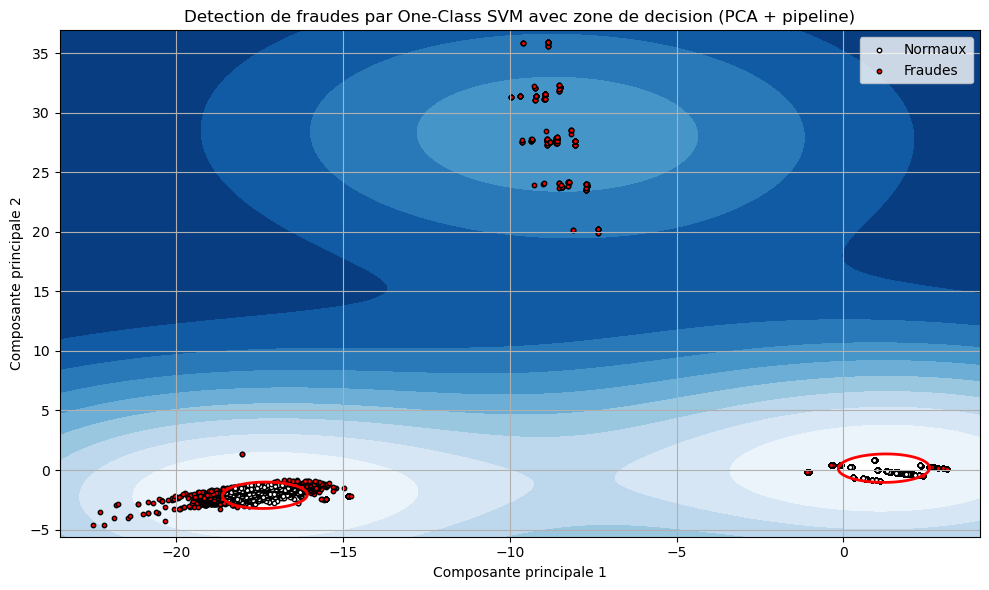

In [95]:
# Chargement du pipeline sauvegardé
with open("../models/svm_transactions.pkl", "rb") as fichier:
    pipeline = pickle.load(fichier)

print("Pipeline chargé avec succès.")

#------------------ Chargemnt des donnees ---------------------
features_new = pd.read_csv("../features/features_transactions.csv")
numeric_cols = features_new.select_dtypes(include=['float64', 'int64']).columns 
X_new = features_new[numeric_cols].fillna(0)

print("Nouvelles donnees chargees.")

#-----------------------Prediction-----------------------
y_pred = pipeline.predict(X_new)

print("Prédiction terminée.")

# --------------------- Visualisation des résultats ----------------------

# Transformation des données pour affichage (PCA réduit à 2 dimensions)
X_transformed = pipeline.named_steps['pca'].transform(pipeline.named_steps['scaler'].transform(X_new))


# --------------------- Visualisation des résultats ----------------------

# Transformation des données pour affichage (PCA réduit à 2 dimensions)
xx, yy = np.meshgrid(
    np.linspace(X_transformed[:, 0].min() - 1, X_transformed[:, 0].max() + 1, 500), 
    np.linspace(X_transformed[:, 1].min() - 1, X_transformed[:, 1].max() + 1, 500)
)

# -----------------------------------Grille a predire avec model SVM --------------------------------
Z = pipeline.named_steps['model'].decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# ---------------------Affichage des résultats avec matplotlib -----------------
plt.figure(figsize=(10, 6))

# Zones de decision ------------------------------------
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 10), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')

# Affichage des points normaux en blanc
plt.scatter(X_transformed[y_pred == 1, 0], X_transformed[y_pred == 1, 1],
            c='white', edgecolors='k', s=10, label="Normaux")
# Affichage des points anrmaux en rouge
plt.scatter(X_transformed[y_pred == -1, 0], X_transformed[y_pred == -1, 1],
            c='red', edgecolors='k', s=10, label="Fraudes")

# Mise en forme
plt.title("Detection de fraudes par One-Class SVM avec zone de decision (PCA + pipeline)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
# Étape 1 : Ajouter les résultats bruts du modèle
features_new['anomalie_svm'] = y_pred  # 1 = normal, -1 = anomalie

# Étape 2 : Créer une colonne binaire plus lisible
features_new['is_fraud_svm'] = features_new['anomalie_svm'].apply(lambda x: 1 if x == -1 else 0)

# (Optionnel) Étape 3 : Ajouter une description textuelle lisible
features_new['fraud_status'] = features_new['is_fraud_svm'].apply(lambda x: "Fraude détectée" if x == 1 else "Normale")

#. Afficher le nombre total de fraudes détectées
nombre_fraudes = features_new['is_fraud_svm'].sum()
print(f"Nombre de fraudes détectées : {nombre_fraudes}")

# Sauvegarde (ajout de is_fraud au dataset)
features_new.to_csv("../features/features_transactions_SVM_pipeline_avec_fraude.csv", index=False)
print("Fichier enrichi avec is_fraud exporté.")

Nombre de fraudes détectées : 2110
Fichier enrichi avec is_fraud exporté.


In [97]:
#Rapport fraude

# Charger les utilisateurs avec les noms
features_df = pd.read_csv("../features/features_transactions.csv")
user_df = pd.read_csv("../datasets/user.csv")
user_df = user_df[['id', 'username', 'matricule']]
user_df.rename(columns={'id': 'user_id'}, inplace=True)  # Pour éviter conflit avec id dans df_fraude

# Charger le fichier des fraudes détectées (contenant la colonne is_fraud)
df_fraude = pd.read_csv('../features/features_transactions_SVM_pipeline_avec_fraude.csv')

# S’assurer que les deux colonnes user_id sont de même type
df_fraude['user_id'] = df_fraude['user_id'].astype(int)
user_df['user_id'] = user_df['user_id'].astype(int)
df_fraude['user_id'] = range(1, len(df_fraude) + 1)

# Fusionner pour ajouter le nom d’utilisateur
df_rapport = pd.merge(df_fraude, user_df[['user_id', 'username', 'matricule']], on='user_id', how='left')

# Regles :

# Règle B1 : montant par jour > 1.000.000 pour un compte personnel
features_df['b1_montant_suspect'] = features_df.apply(
    lambda row: 1 if row.get('signup_mode_PERSONNAL') == 1 and row.get('montant_par_jour', 0) > 1_000_000 else 0,
    axis=1
)

# Règle B2 : KYC absent
features_df['b2_kyc_absent'] = features_df.get('kyc_status_NOT_INITIATED', 0).fillna(0).astype(bool).astype(int)

# Règle B3 : montant > solde
features_df['b3_montant_trade_exces'] = features_df.apply(lambda row: 1 if row['amount'] > row.get('trade_balance', 0) else 0, axis=1)

#
colonnes_regles = ['b1_montant_suspect', 'b2_kyc_absent', 'b3_montant_trade_exces']
for col in colonnes_regles:
    if col in features_df.columns:
        df_rapport[col] = features_df[col]

# Description
def generer_description(row):
    raisons = []
    if row.get('b1_montant_suspect', False) or row.get('montant_eleve_jour', 0) == 1:
        raisons.append("Montant élevé détecté sur une journée")
    if row.get('b2_kyc_absent', False):
        raisons.append("KYC non validé")
    if row.get('b3_montant_trade_exces', False):
        raisons.append("Montant superieur au solde")
    return "/ ".join(raisons) if raisons else "comportement suspect détecté par le modèle"
    
# Application
df_rapport['description'] = df_rapport.apply(
    lambda row: generer_description(row) if row['is_fraud_svm'] == 1 else "",
    axis=1
)

# . Sélection des colonnes intéressantes pour le rapport
colonnes_affichage = ['user_id', 'username_y', 'matricule_y', 'is_fraud_svm', 'description']
rapport_final = df_rapport[df_rapport['is_fraud_svm'] == 1][colonnes_affichage]

# .suppression des lignes avec des valeurs manquantes (NaN)
rapport_final = rapport_final.dropna(subset=['matricule_y', 'username_y', 'user_id'])

#9. Convertir la colonne 'id' en int
rapport_final['user_id'] = rapport_final['user_id'].astype(int)

# Exporter vers CSV
rapport_final.to_csv("../features/rapport_fraude_transactions_SVM_pipeline.csv", index=False)

# Affichage d’un aperçu
print("Utilisateurs détectés comme fraudeurs :")
display(rapport_final.head())

Utilisateurs détectés comme fraudeurs :


,user_id,username_y,matricule_y,is_fraud_svm,description
32,33,immoleas,SP202133A,1,KYC non validé
54,55,Ngang Kellymorra tengue,SP202255U,1,KYC non validé
58,59,DJOUMESSI RUSEL,SP202259M,1,KYC non validé
80,81,Jules César KETCHAKOU,SP202281U,1,KYC non validé
84,85,MagicGode,SP202285M,1,KYC non validé


In [75]:
#--------- alogorithme k-means --------

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [98]:
# 2. Appliquer K-Means
df = pd.read_csv("../features/features_transactions.csv") 

# filtrage des colonnes numeriques
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns 
df[numeric_cols] = df[numeric_cols].fillna(0) 
X = df[numeric_cols]

# ---------------------pipeline ---------------------------
k = 3  # Nombre de clusters
pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Normalisation des données
    ('pca', PCA(n_components=2, random_state=42)),         # Réduction de dimension
    ('model', KMeans(
        n_clusters=k,
        random_state=42
    ))
])

# Entrainement
pipeline.fit(X)
y_pred = pipeline.predict(X)

# Sauvegarde du pipeline complet
with open("../models/kmeans_transactions.pkl", "wb") as fichier:
    pickle.dump(pipeline, fichier)

print("Pipeline K-Means + PCA + Scaler sauvegardé avec succès.")


Pipeline K-Means + PCA + Scaler sauvegardé avec succès.


In [99]:
# -------------------- 3. Afficher les centroïdes (version corrigée avec pipeline) --------------------

# On récupère le modèle KMeans depuis le pipeline
kmeans_model = pipeline.named_steps['model']

# Les centroïdes sont dans l’espace PCA (2D)
centroids_pca = pd.DataFrame(
    kmeans_model.cluster_centers_,
    columns=['PC1', 'PC2']
)

print("Centroïdes des clusters (dans l’espace PCA) :")
print(centroids_pca)

Centroïdes des clusters (dans l’espace PCA) :
         PC1        PC2
0   1.440484  -0.135654
1 -17.632061  -2.026361
2  -8.562076  28.252595


In [100]:
# -------------------- 4. Attribution des clusters --------------------

# Appliquer la prédiction de cluster à nos données initiales
features_df['cluster_kmeans'] = pipeline.predict(X)

# -------------------- 5. Détection des fraudes (cluster minoritaire) --------------------

# Trouver le cluster minoritaire
cluster_counts = features_df['cluster_kmeans'].value_counts()
if len(cluster_counts) > 1:
    cluster_minoritaire = cluster_counts.idxmin()  # <- ici le cluster avec le moins d'occurrences
    print(f"Cluster minoritaire identifié : {cluster_minoritaire}")

    # Attribuer fraude si l'utilisateur appartient au cluster minoritaire
    features_df['is_fraud_kmeans'] = features_df['cluster_kmeans'].apply(
        lambda c: 1 if c == cluster_minoritaire else 0
    )
else:
    # Si un seul cluster, on considère tout comme normal
    features_df['is_fraud_kmeans'] = 0

# Optionnel : description lisible
features_df['fraud_status_kmeans'] = features_df['is_fraud_kmeans'].apply(
    lambda x: "Fraude suspectée (cluster isolé)" if x == 1 else "Normal"
)
features_df.to_csv("../features/features_transactions_kmeans_avec_fraude.csv", index=False)
print("Fichier enrichi avec cluster et is_fraud exporté avec succès.")


Cluster minoritaire identifié : 2
Fichier enrichi avec cluster et is_fraud exporté avec succès.


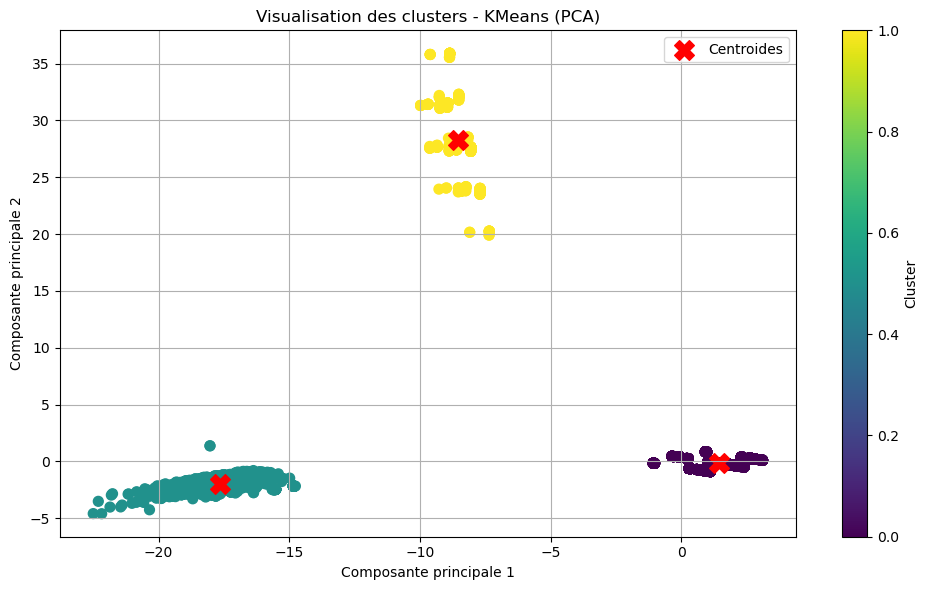

In [101]:
# -------------------- 7. Visualisation des clusters en 2D via le pipeline (pas besoin de refaire un PCA) --------------------

X_pca = pipeline.named_steps['pca'].transform(
    pipeline.named_steps['scaler'].transform(X)
)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=features_df['cluster_kmeans'], cmap='viridis', s=50)
plt.scatter(centroids_pca['PC1'], centroids_pca['PC2'], c='red', s=200, marker='X', label='Centroides')
plt.title("Visualisation des clusters - KMeans (PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(label="Cluster")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [102]:
# 5. Sauvegarder le DataFrame avec les clusters
features_df.to_csv("../features/features_transactions_kmeans_sales_clusters.csv", index=False)
print("Fichier exporté : features_transactions_kmeans_sales_clusters.csv")

Fichier exporté : features_transactions_kmeans_sales_clusters.csv


In [103]:
# Étape 1 : Chargement du fichier des clusters (généré après KMeans)
features_df = pd.read_csv('../features/features_transactions_kmeans_sales_clusters.csv')

# Étape 2 : Suppression des doublons sur la colonne 'user_id'
# On garde la première occurrence pour chaque user_id
features_df_propre = features_df.drop_duplicates(subset='user_id', keep='first')

# Étape 3 : Vérification (facultatif)
print("Nombre total de lignes AVANT suppression des doublons :", features_df.shape[0])
print("Nombre total de lignes APRÈS suppression des doublons :", features_df_propre.shape[0])

# Étape 4 : Sauvegarde dans un nouveau fichier CSV
chemin_sortie = '../features/features_transactions_kmeans_avecc_clusters.csv'
features_df_propre.to_csv(chemin_sortie, index=False)

print(f"Fichier exporté avec succès : {chemin_sortie}")

Nombre total de lignes AVANT suppression des doublons : 37984
Nombre total de lignes APRÈS suppression des doublons : 2677
Fichier exporté avec succès : ../features/features_transactions_kmeans_avecc_clusters.csv


In [104]:
#fusion des resultats clustering + detection de fraudes

# 1. Charger les fichiers
clusters_df = pd.read_csv("../features/features_transactions_kmeans_avec_fraude.csv")  # Contient la colonne 'cluster'
isoforest_df = pd.read_csv("../features/features_transactions_isolation_forest_pipeline_avec_fraude.csv")  # Contient 'is_fraud'
svm_df = pd.read_csv("../features/features_transactions_SVM_pipeline_avec_fraude.csv")  # Contient 'is_fraud'

# 2. Renommer les colonnes pour éviter les conflits
isoforest_df = isoforest_df.rename(columns={"is_fraud": "is_fraud_isolation"})
svm_df = svm_df.rename(columns={"is_fraud_svm": "is_fraud_svm"})

# === Vérifier que l’index est bien aligné pour chaque fichier ===
clusters_df = clusters_df.reset_index(drop=True)
isoforest_df = isoforest_df.reset_index(drop=True)
svm_df = svm_df.reset_index(drop=True)

# === Fusionner les DataFrames sur l’index (ligne = utilisateur) ===
fusion_temp = pd.concat([clusters_df, isoforest_df["is_fraud_isolation"], svm_df["is_fraud_svm"]], axis=1)

# === Sauvegarder le fichier final fusionné ===
fusion_temp.to_csv("../features/features_clusters_transactions_isoforest_svm_kmeans_pipeline.csv", index=False)
print("Fichier fusionné exporté sous : features_clusters_transactions_isoforest_svm_kmeans_pipeline.csv")

# 5. Aperçu du résultat
print(fusion_temp.head())

Fichier fusionné exporté sous : features_clusters_transactions_isoforest_svm_kmeans_pipeline.csv
   user_id  username  date_start  last_operation   balance  nb_trans  \
0      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   
1      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   
2      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   
3      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   
4      0.0  0.001494  1970-01-01        0.855809  0.199932       0.0   

    contact  rewards_balance  matricule  last_login  ...  currency_id_15.0  \
0  0.000374              1.0   0.000374    0.000374  ...               0.0   
1  0.000374              1.0   0.000374    0.000374  ...               0.0   
2  0.000374              1.0   0.000374    0.000374  ...               0.0   
3  0.000374              1.0   0.000374    0.000374  ...               0.0   
4  0.000374              1.0   0.000374    0.000374  ...               0.0   

 

In [105]:
#rapport clusters

# 1. Charger le fichier fusionné
# Ce fichier doit contenir les colonnes : cluster, is_fraud_isolation, is_fraud_svm
df = pd.read_csv("../features/features_clusters_transactions_isoforest_svm_kmeans_pipeline.csv")

# 2. Grouper les utilisateurs par cluster et compter
rapport = df.groupby("cluster_kmeans").agg(
    total_utilisateurs=("cluster_kmeans", "count"),                  # Total d'utilisateurs dans chaque cluster
    nb_fraudes_isoforest=("is_fraud_isolation", "sum"),       # Total de fraudes détectées par Isolation Forest
    nb_fraudes_svm=("is_fraud_svm", "sum")                    # Total de fraudes détectées par SVM
)

# 3. Calculer les taux de fraude (%) par méthode
rapport["taux_fraude_isoforest (%)"] = (
    rapport["nb_fraudes_isoforest"] / rapport["total_utilisateurs"] * 100
).round(2)

rapport["taux_fraude_svm (%)"] = (
    rapport["nb_fraudes_svm"] / rapport["total_utilisateurs"] * 100
).round(2)

# 4. Afficher le rapport
print("=== Rapport de Fraude par Cluster (base sur kmeans) ===")
print(rapport)

# 5. Sauvegarder le rapport en CSV si besoin
rapport.to_csv("../features/rapport_fraude_transactions_par_cluster_pipeline.csv", index=True)
print("\nRapport exporté : rapport_fraude_transactions_par_cluster_pipeline.csv")

=== Rapport de Fraude par Cluster (base sur kmeans) ===
                total_utilisateurs  nb_fraudes_isoforest  nb_fraudes_svm  \
cluster_kmeans                                                             
0                            34944                  1400             976   
1                             2680                  2039             774   
2                              360                   360             360   

                taux_fraude_isoforest (%)  taux_fraude_svm (%)  
cluster_kmeans                                                  
0                                    4.01                 2.79  
1                                   76.08                28.88  
2                                  100.00               100.00  

Rapport exporté : rapport_fraude_transactions_par_cluster_pipeline.csv


In [106]:
# Vérifie les types
print("Type clusters_df :", clusters_df['user_id'].dtype)
print("Type svm_df :", svm_df['user_id'].dtype)
print("Type iso_forest_df :", svm_df['user_id'].dtype)
print("Type users_df :", svm_df['user_id'].dtype)

# Liste des IDs présents dans chaque fichier
print("Nb IDs dans clusters_df :", clusters_df['user_id'].nunique())
print("Nb IDs dans svm_df :", svm_df['user_id'].nunique())

# Affiche les user_id qui existent dans svm mais pas dans clusters
ids_svm = set(svm_df['user_id'])
ids_clusters = set(clusters_df['user_id'])

ids_manquants = ids_svm - ids_clusters
print("Nb IDs présents dans SVM mais absents dans clusters :", len(ids_manquants))

Type clusters_df : float64
Type svm_df : float64
Type iso_forest_df : float64
Type users_df : float64
Nb IDs dans clusters_df : 2677
Nb IDs dans svm_df : 2677
Nb IDs présents dans SVM mais absents dans clusters : 0


In [107]:
#  Rapport final

# Étape 1 : Chargement des fichiers
clusters_df = pd.read_csv("../features/features_transactions_kmeans_avecc_clusters.csv")
isoforest_df = pd.read_csv("../features/rapport_fraude_transactions_isoforest_pipeline.csv")
svm_df = pd.read_csv("../features/rapport_fraude_transactions_SVM_pipeline.csv")
users_df = pd.read_csv("../datasets/user.csv")

# Étape 2 : Renommage pour éviter les conflits
users_df = users_df.rename(columns={'id': 'user_id'})
isoforest_df = isoforest_df.rename(columns={'is_fraud': 'is_fraud_isolation'})
svm_df = svm_df.rename(columns={'is_fraud': 'is_fraud_svm'})


# S'assurer ques les ID sont bien en int
# Assurer que les identifiants sont bien en int
users_df['user_id'] = users_df['user_id'].astype(int)
clusters_df['user_id'] = clusters_df['user_id'].astype(int)
isoforest_df['user_id'] = isoforest_df['user_id'].astype(int)
svm_df['user_id'] = svm_df['user_id'].astype(int)

# Forcer tous les user_id en int32
for df in [clusters_df, svm_df, isoforest_df, users_df]:
    df["user_id"] = df["user_id"].astype("int64")

# Conversion de id pretraites en id brut
clusters_df['user_id'] = range(1, len(clusters_df) + 1)

# Vérifie les types
print("Type clusters_df :", clusters_df['user_id'].dtype)
print("Type svm_df :", svm_df['user_id'].dtype)
print("Type iso_forest_df :", svm_df['user_id'].dtype)
print("Type users_df :", svm_df['user_id'].dtype)

# Fusion des resultats
fusion_temp = pd.merge(clusters_df, isoforest_df[['user_id', 'is_fraud_isolation', 'description']], on='user_id', how='left')
fusion_finale = pd.merge(fusion_temp, svm_df[['user_id', 'is_fraud_svm']], on='user_id', how='left')

# ajout des noms d'utilisateurs
rapport_avec_noms = pd.merge(fusion_finale, users_df[['user_id', 'username', 'matricule']], on='user_id', how='left')

# Réorganiser les colonnes dans l'ordre souhaité ===
colonnes_ordre = ['user_id', 'username_y', 'matricule_y', 'cluster_kmeans', 'is_fraud_isolation', 'is_fraud_svm', 'description']
rapport_avec_noms = rapport_avec_noms[colonnes_ordre]

# Supprimer les lignes avec des valeurs manquantes
rapport_complet = rapport_avec_noms.dropna()

# Afficher un aperçu du rapport nettoyé
print("Aperçu du rapport sans valeurs manquantes :")
display(rapport_complet)

# Étape 8 : Exporter le rapport propre
chemin_propre = "../features/rapport_fraude_transactions_clusters.csv"
rapport_complet.to_csv(chemin_propre, index=False)

print(f"\nRapport propre exporté avec succès : {chemin_propre}")

Type clusters_df : int64
Type svm_df : int64
Type iso_forest_df : int64
Type users_df : int64
Aperçu du rapport sans valeurs manquantes :


,user_id,username_y,matricule_y,cluster_kmeans,is_fraud_isolation,is_fraud_svm,description
218,219,Jujulove,SP2022219U,1,1.0,1.0,KYC non validé
220,221,Armelle,SP2022221U,1,1.0,1.0,KYC non validé
222,223,Samanta samidjo,SP2022223U,1,1.0,1.0,KYC non validé
228,229,Blondy,SP2022229U,1,1.0,1.0,KYC non validé
243,244,Yannick,SP2022244A,1,1.0,1.0,KYC non validé
...,...,...,...,...,...,...,...
408,409,merveilleflavytsamotankeu,SP2023409M,1,1.0,1.0,KYC non validé
410,411,mcorallye,SP2023411M,1,1.0,1.0,KYC non validé
411,412,Meridians,SP2023412A,1,1.0,1.0,KYC non validé
412,413,ahmar6553@gmail.com,SP2023413A,1,1.0,1.0,KYC non validé



Rapport propre exporté avec succès : ../features/rapport_fraude_transactions_clusters.csv
